<a href="https://colab.research.google.com/github/Kuizinass/AI-Projects/blob/main/05_transfer_learning_02_fine_tuninig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 2: Transfer learning, this time more about fine tuning

## Creating helper function

Previously we have created some helper functions we could re-write them, but there are better ways

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-06-25 15:13:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-25 15:13:29 (93.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-06-25 15:13:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  96.6MB/s    in 1.7s    

2024-06-25 15:13:32 (96.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [ ]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.58571396e+01 2.46836739e+01 1.88775492e+00]
   [5.90459175e+01 3.18316345e+01 4.95408297e+00]
   [5.24285736e+01 2.90714302e+01 1.69897997e+00]
   ...
   [3.80713615e+01 2.06428356e+01 2.85709906e+00]
   [3.64744987e+01 1.94744987e+01 7.14285612e-01]
   [3.73010445e+01 2.23010426e+01 1.30104268e+00]]

  [[5.88877563e+01 2.88877563e+01 2.97959185e+00]
   [5.61326523e+01 2.99795914e+01 2.98469400e+00]
   [5.78877563e+01 3.45306129e+01 6.31632710e+00]
   ...
   [4.03009758e+01 2.28724480e+01 5.51523972e+00]
   [3.79949226e+01 2.09949245e+01 1.06124914e+00]
   [4.34286423e+01 2.64286423e+01 6.42864227e+00]]

  [[6.50459213e+01 3.73418388e+01 1.06224489e+01]
   [5.59285660e+01 2.98724480e+01 2.87244749e+00]
   [5.75000000e+01 3.40051003e+01 5.83673382e+00]
   ...
   [4.05510521e+01 2.27857800e+01 5.59694386e+00]
   [3.99285851e+01 2.25000134e+01 3.14287090e+00]
   [4.49286766e+01 2.75001049e+01 8.14296246e+00]]

  ...

  [[1.03418159e+01 1.11224804e+01 6.37762785e-01]
   [1

## Let's buidl our first Functiona API model

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240625-151346
Epoch 1/5
24/24 [==============================] - 19s 297ms/step - loss: 1.9544 - accuracy: 0.3827 - val_loss: 1.4003 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - 5s 181ms/step - loss: 1.1773 - accuracy: 0.7520 - val_loss: 0.9494 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 3s 127ms/step - loss: 0.8587 - accuracy: 0.8160 - val_loss: 0.7719 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.7008 - accuracy: 0.8453 - val_loss: 0.6725 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 4s 168ms/step - loss: 0.5992 - accuracy: 0.8600 - val_loss: 0.6122 - val_accuracy: 0.8470


In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
# Let's look at the model summary
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
# How about our model_0 summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

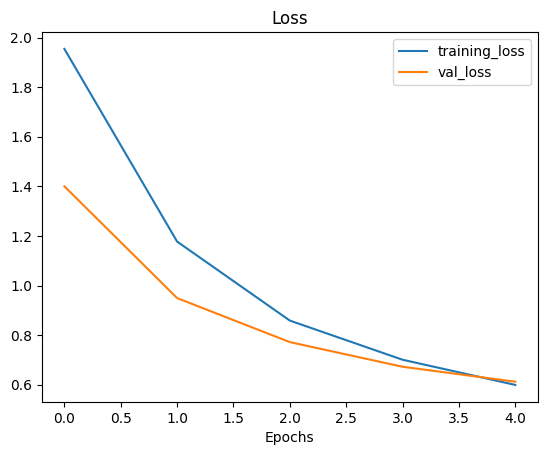

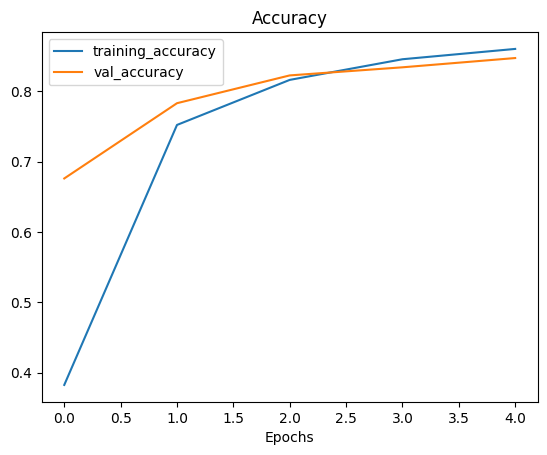

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

Why don't we answer that question while running the following modelling experiments:

Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.

Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.

Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-06-25 15:14:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   259MB/s    in 0.5s    

2024-06-25 15:14:38 (259 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [ ]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

In [ ]:
# Data augmentation
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

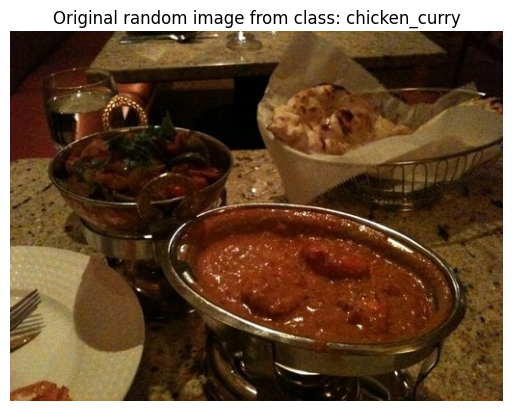

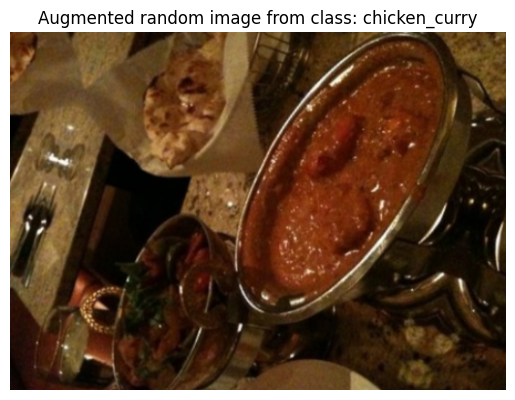

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240625-151446
Epoch 1/5
3/3 [==============================] - 16s 3s/step - loss: 2.3761 - accuracy: 0.1000 - val_loss: 2.2567 - val_accuracy: 0.1530
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.1258 - accuracy: 0.2429 - val_loss: 2.1403 - val_accuracy: 0.2220
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9526 - accuracy: 0.4000 - val_loss: 2.0076 - val_accuracy: 0.3322
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.8164 - accuracy: 0.5143 - val_loss: 1.9363 - val_accuracy: 0.3520
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6835 - accuracy: 0.6286 - val_loss: 1.8486 - val_accuracy: 0.4276


In [ ]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 90ms/step - loss: 1.8658 - accuracy: 0.4232


[1.8657519817352295, 0.42320001125335693]

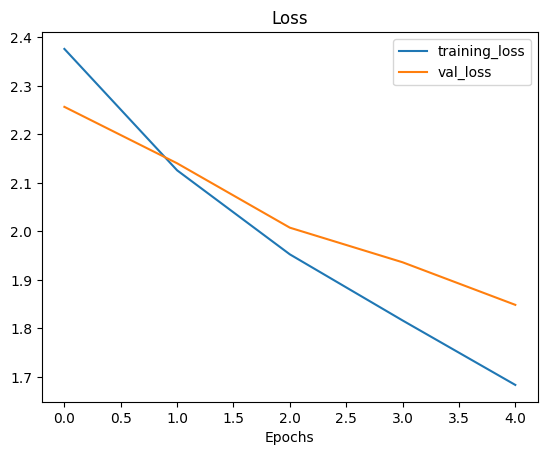

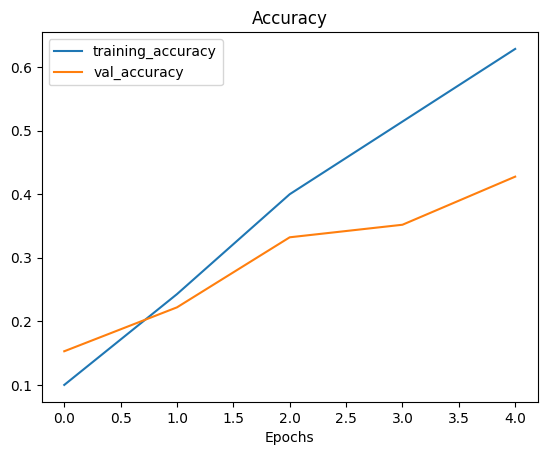

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

## Creating a ModelCheckpoint Callback

The 'ModelCheckpoint' callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240625-151545
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0576 - accuracy: 0.3187
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 37s 1s/step - loss: 2.0576 - accuracy: 0.3187 - val_loss: 1.5302 - val_accuracy: 0.6102
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4220 - accuracy: 0.6507
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 1s/step - loss: 1.4220 - accuracy: 0.6507 - val_loss: 1.0522 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1104 - accuracy: 0.7227
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 1s/step - loss: 1.1104 - accuracy: 0.7227 - val_loss: 0.8191 - val_accuracy: 0.8207
Epoch 4/5


In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 69ms/step - loss: 0.6484 - accuracy: 0.8384


[0.6483641862869263, 0.8384000062942505]

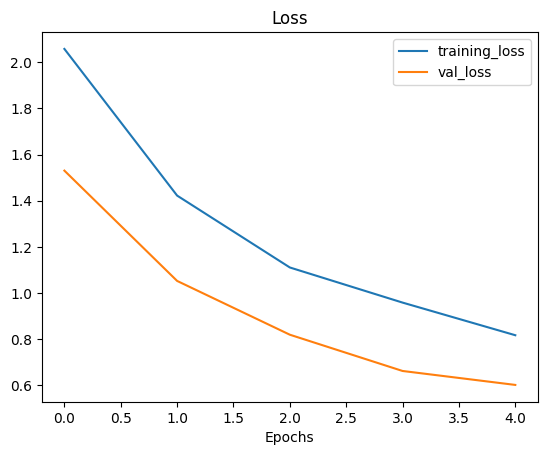

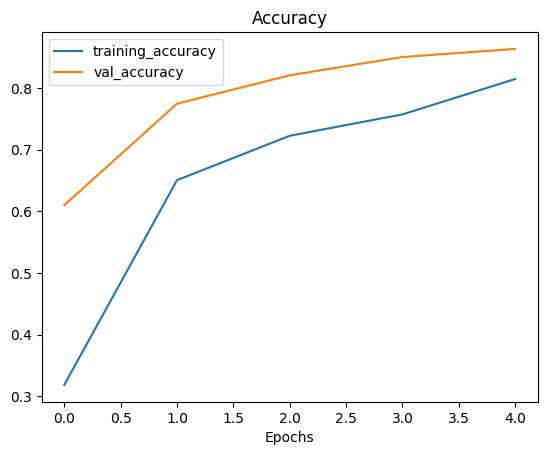

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.6484 - accuracy: 0.8384


In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3. Finetuning the existing model on 10% of the data

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are the layers trainable?
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7a1e466a35e0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7a1e46798cd0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7a1e42af7010> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a1e5063a590> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7a1e42b50460> | Trainable? True


In [ ]:
# Let's look at model_2 summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [ ]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

🔑 Note: There's no set standard for setting the learning rate during fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# How many training variables do we have now?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240625-151823
Epoch 5/10
24/24 [==============================] - 32s 900ms/step - loss: 0.6984 - accuracy: 0.8200 - val_loss: 0.4757 - val_accuracy: 0.8651
Epoch 6/10
24/24 [==============================] - 17s 701ms/step - loss: 0.5715 - accuracy: 0.8320 - val_loss: 0.4278 - val_accuracy: 0.8635
Epoch 7/10
24/24 [==============================] - 20s 794ms/step - loss: 0.5237 - accuracy: 0.8373 - val_loss: 0.4388 - val_accuracy: 0.8503
Epoch 8/10
24/24 [==============================] - 16s 659ms/step - loss: 0.4822 - accuracy: 0.8560 - val_loss: 0.4175 - val_accuracy: 0.8734
Epoch 9/10
24/24 [==============================] - 15s 613ms/step - loss: 0.4819 - accuracy: 0.8467 - val_loss: 0.3826 - val_accuracy: 0.8684
Epoch 10/10
24/24 [==============================] - 17s 672ms/step - loss: 0.4560 - accuracy: 0.8547 - val_loss: 0.3733 - val_accuracy: 0.8684


In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4514 - accuracy: 0.8492


In [ ]:
# Create a function to training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3186666667461395, 0.6506666541099548, 0.7226666808128357, 0.7573333382606506, 0.8146666884422302, 0.8199999928474426, 0.8320000171661377, 0.8373333215713501, 0.8560000061988831, 0.846666693687439, 0.8546666502952576]


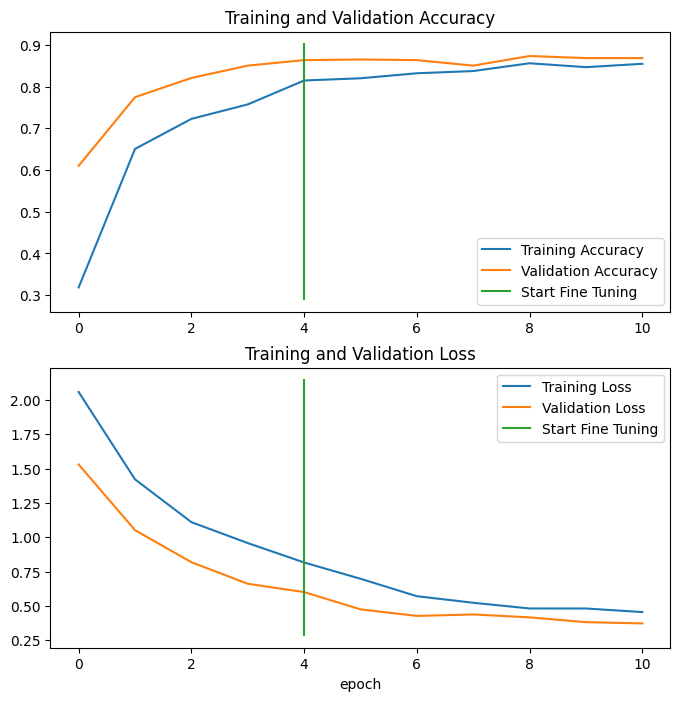

In [ ]:
# Now let's run the function and see the comparison
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2024-06-25 16:02:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  79.7MB/s    in 7.0s    

2024-06-25 16:02:53 (71.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.4514 - accuracy: 0.8492


[0.4514107406139374, 0.8492000102996826]

In [ ]:
results_fine_tune_10_percent

[0.45141080021858215, 0.8492000102996826]

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [ ]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [ ]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 74ms/step - loss: 0.6484 - accuracy: 0.8384


[0.648364245891571, 0.8384000062942505]

In [ ]:
results_10_percent_data_aug

[0.6483641862869263, 0.8384000062942505]

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240625-162154
Epoch 5/10
235/235 [==============================] - 133s 522ms/step - loss: 0.7217 - accuracy: 0.7691 - val_loss: 0.3887 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 101s 429ms/step - loss: 0.6023 - accuracy: 0.8064 - val_loss: 0.3687 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 85s 360ms/step - loss: 0.5407 - accuracy: 0.8275 - val_loss: 0.3445 - val_accuracy: 0.8799
Epoch 8/10
235/235 [==============================] - 73s 308ms/step - loss: 0.5040 - accuracy: 0.8368 - val_loss: 0.3111 - val_accuracy: 0.8931
Epoch 9/10
235/235 [==============================] - 65s 276ms/step - loss: 0.4859 - accuracy: 0.8377 - val_loss: 0.2920 - val_accuracy: 0.9062
Epoch 10/10
235/235 [==============================] - 61s 258ms/step - loss: 0.4519 - accuracy: 0.8535 - val_loss: 0.2629 - val_accuracy: 0.9079


In [ ]:
# Now let's evaluate on all test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 8s 92ms/step - loss: 0.2640 - accuracy: 0.9148


[0.2640298008918762, 0.9147999882698059]

In [ ]:
results_fine_tune_10_percent

[0.45141080021858215, 0.8492000102996826]

5
11
[0.3186666667461395, 0.6506666541099548, 0.7226666808128357, 0.7573333382606506, 0.8146666884422302, 0.7690666913986206, 0.8064000010490417, 0.8274666666984558, 0.8367999792098999, 0.8377333283424377, 0.8534666895866394]


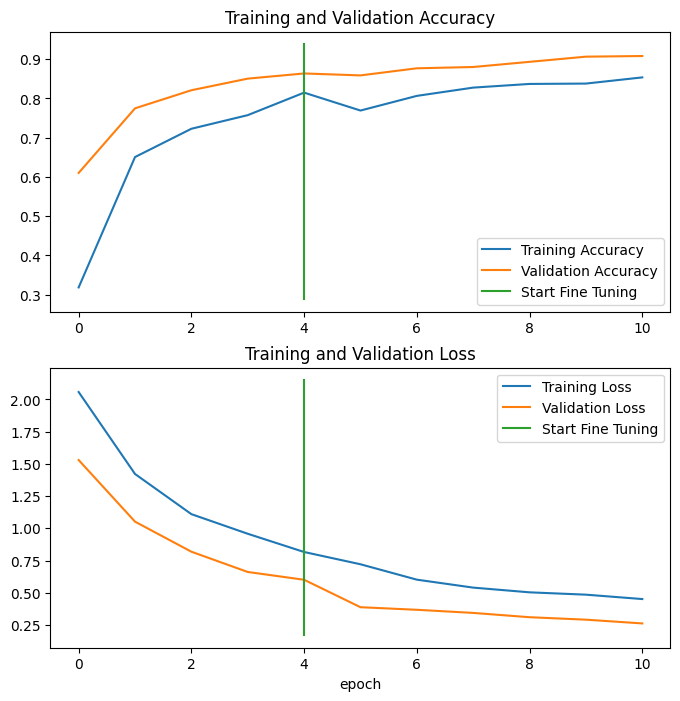

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)